<a href="https://colab.research.google.com/github/ZacharySBrown/vcu-scma440-2021q1/blob/master/examples/6a_multiple_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Fetch Data
Press the play button in Google Colab or press Shift+Enter execute the cell below to download and load the data and packages for this assignment

This will setup you environment and load a DataFrame called `bankdata` that contains the bank data from Makridakis Chapter 6. as well as `bankdata_test` which contains the last year of the bank data as a hold out set

In [94]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display


from scipy.stats import t, f

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16

!curl https://vcu-scma-440.s3.amazonaws.com/data/bankdata.csv > bankdata.csv

bankdata = pd.read_csv('bankdata.csv', parse_dates=['date']).set_index('date').rename(columns={'34': 'mo_34'})
bankdata['d_balance'] = bankdata['balance'].diff()
bankdata = bankdata.dropna()

bankdata_test = bankdata[-12:]
bankdata = bankdata[:-12]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1687  100  1687    0     0   9372      0 --:--:-- --:--:-- --:--:--  9372


# Previous Analysis

As before, we'll execute the following steps:
* Compute correlations
* Fit a simple linear model

Note here that for simplicity, we are not creating differenced versions of our independent variables, or dummy variables. A differenced version of the dependent variable `d_balance` has already been created. 

,balance,aaa,mo_34,d_balance
balance,1.000000,0.400233,-0.340401,0.549856
aaa,0.400233,1.000000,0.596279,0.200159
mo_34,-0.340401,0.596279,1.000000,-0.456494
d_balance,0.549856,0.200159,-0.456494,1.000000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              d_balance   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     27.39
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           1.87e-08
Time:                        16:45:14   Log-Likelihood:                -426.26
No. Observations:                  47   AIC:                             858.5
Df Residuals:                      44   BIC:                             864.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4669.5457   3391.347     -1.377      0.176   -1.15e+04    2165.265
aaa         3465.0551    592.489      5.848      0.000    2270.972    4659.138
mo_34      -2899.5653    406.694     -7.130      0.000   -3719.204   -2079.927
==============================================================================
Omnibus:                        0.284   Durbin-Watson:                   1.444
Prob(Omnibus):                  0.868   Jarque-Bera (JB):                0.024
Skew:                          -0.049   Prob(JB):                        0.988
Kurtosis:                       3.050   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

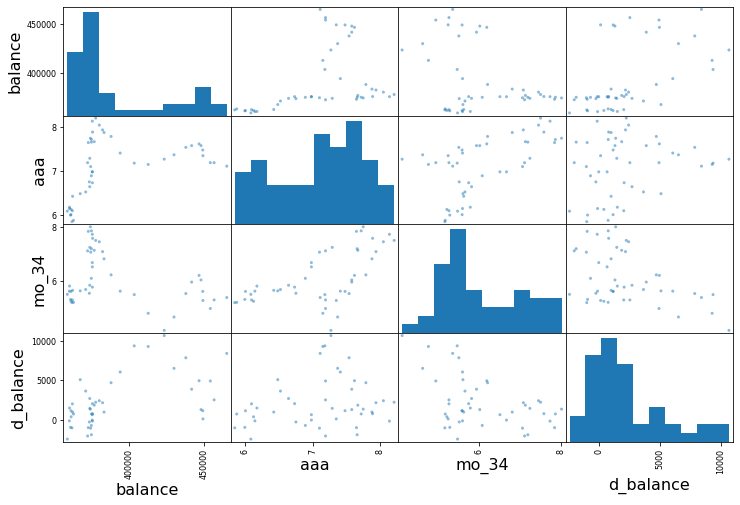

In [95]:
# Plot a scatter matrix of the data
my_figure = pd.plotting.scatter_matrix(bankdata)

# Print out the correlations for our data
display(bankdata.corr())

# Fit a basic linear model
regression_model = ols('d_balance ~ aaa + mo_34', bankdata)
regression_results = regression_model.fit()
display(regression_results.summary())

We can do a quick qualitative check of the fit by saving the `regression_results.fittedvalues` to a new column in our `DataFrame` and plotting that along with the original data for `d_balance`

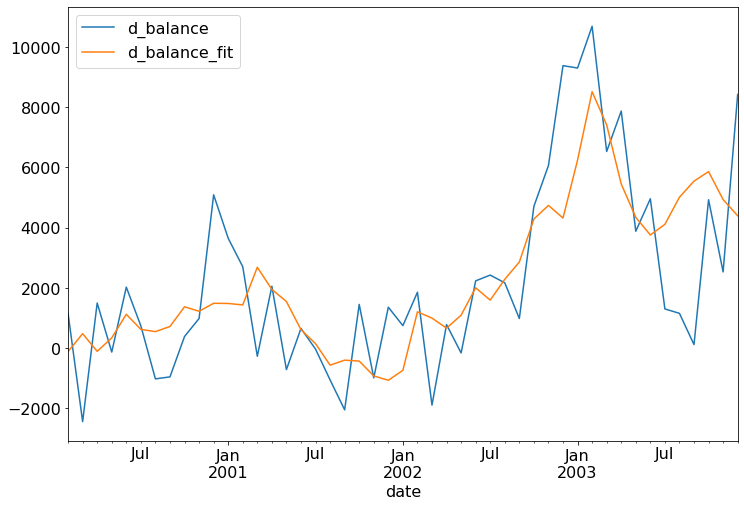

In [98]:
fitted_values = regression_results.fittedvalues
bankdata['d_balance_fit'] = fitted_values

bankdata[['d_balance','d_balance_fit']].plot()

# Forecasting independent variables

If we want to forecast with this model, we'll need to predict the unknown future values of our independent variables. To do this, we'll use Holt's linear method to forecast the values of `aaa` and `mo_34`. 

Let's first take a look at `aaa`

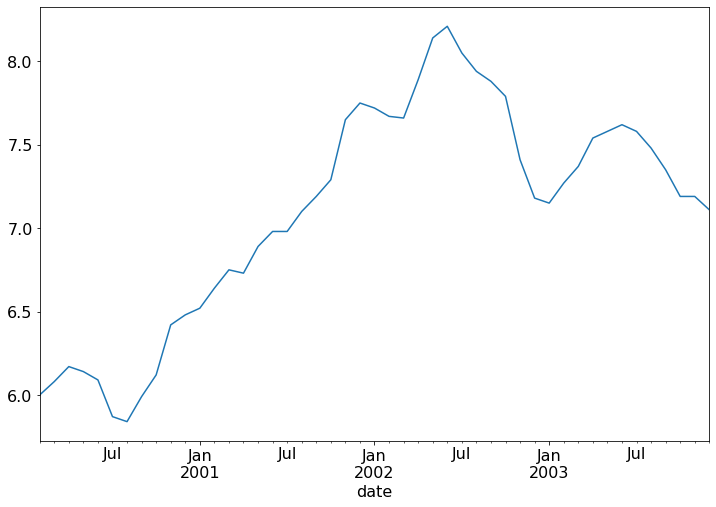

In [99]:
bankdata['aaa'].plot()

Recall that to use Holt's linear method, we need to walk through the following steps:
1. Create a `model` by feeding in our data
2. Fit the model, specifying the smoothing factor for the level and slope (`smoothing_level` and `smoothing_slope`)

_Note: we are not specifying the `initial_level` and `initial_slope` here, so they will be determined automatically_

/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  after removing the cwd from sys.path.


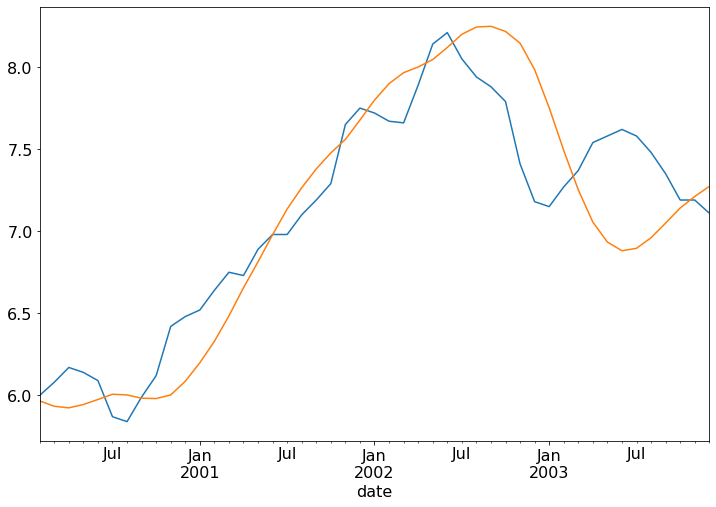

In [101]:
aaa_model = Holt(bankdata['aaa'])
aaa_results = aaa_model.fit(
    smoothing_level=0.1, 
    smoothing_slope=0.8,

    )

bankdata['aaa_fit'] = aaa_results.fittedvalues
bankdata['aaa'].plot()
bankdata['aaa_fit'].plot()

This probably isn't the _best_ job that we can do forecasting `aaa`, but it will suffice for now. Let's move on to forecasting `mo_34`, for which we'll follow the exact same steps as above. 

/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  after removing the cwd from sys.path.


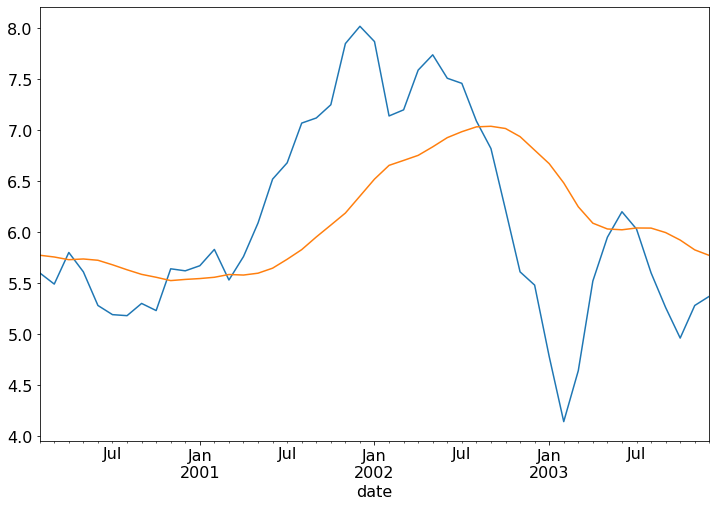

In [102]:
mo_34_model = ExponentialSmoothing(bankdata['mo_34'])
mo_34_results = mo_34_model.fit(
    smoothing_level=0.1, 
    smoothing_slope=0.8
    )

bankdata['mo_34_fit'] = mo_34_results.fittedvalues
bankdata['mo_34'].plot()
bankdata['mo_34_fit'].plot()

Again, this isn't the perfect fit for the observed data, but it will do for our purposes.  

# Making Predictions for Independent Variables

Now that we have smoothing forecast _models_ for our independent variables, we need to use them to actually _make forecasts_ for the next 12 months. To do this, we'll use the `model.predict()` function, which takes in the model parameters, as well as the starting and ending index over which we want to make predictions. We can access the values of the parameters for a model by calling `model.params`.

For our purposes, we want to make predictions for 12 months _beyond_ the length of our original `bankdata` `DataFrame`, so we'll create `start` and `end` variables to feed into the `model.predict()` function:

In [106]:
# Forecast for N months out
N_months = 12

# Start of window for our prediction
start = bankdata.shape[0]
# End of window for our prediction
end = bankdata.shape[0] + N - 1

aaa_predictions = aaa_model.predict(aaa_model.params, start, end)

mo_34_predictions = mo_34_model.predict(mo_34_model.params, start, end)

Now that we have these predictions, we'll need to put them in the same format that our `regression_model` expects, where the first column is called `Intercept` and contains all ones, the second column contains the values of `aaa`, and the third contains the values of `mo_34`. To do this, we'll create a new `DataFrame` (using the index from our `bankdata_test` so we have the same time index), and then add the necessary columns in order.

In [107]:
indep_predictions = pd.DataFrame(index=bankdata_test.index)
indep_predictions['Intercept'] = [1.0] * N
indep_predictions['aaa'] = aaa_predictions
indep_predictions['mo_34'] = mo_34_predictions

# Forecasting the Independent variable

Now that we have our forcast values for the _independent_ variables, we can use those as input to make predictions of our _dependent_ variable with our `regression_model`. To predict with out `regression_model`, we can use the `regression_model.predict()` function, which again takes the model parameters as the first argument. The second argument however is the `DataFrame` of _forecasted independent_ variables that we created above:

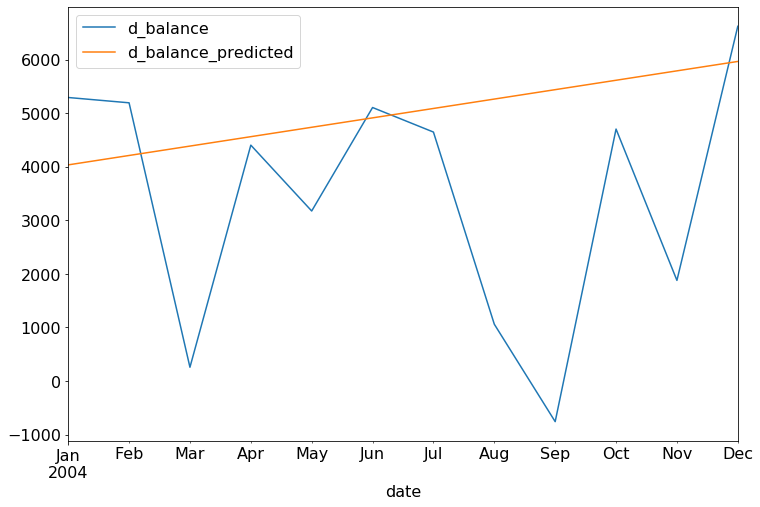

In [108]:
regression_predictions = regression_model.predict(regression_results.params, indep_predictions)
bankdata_test['d_balance_predicted'] = regression_predictions

bankdata_test[['d_balance','d_balance_predicted']].plot()

To gain some intuition around the linear nature of the regression forecast, consider the shape of the forecasts of the _independent_ varaibles (recall we are using Holt's _linear_ method):

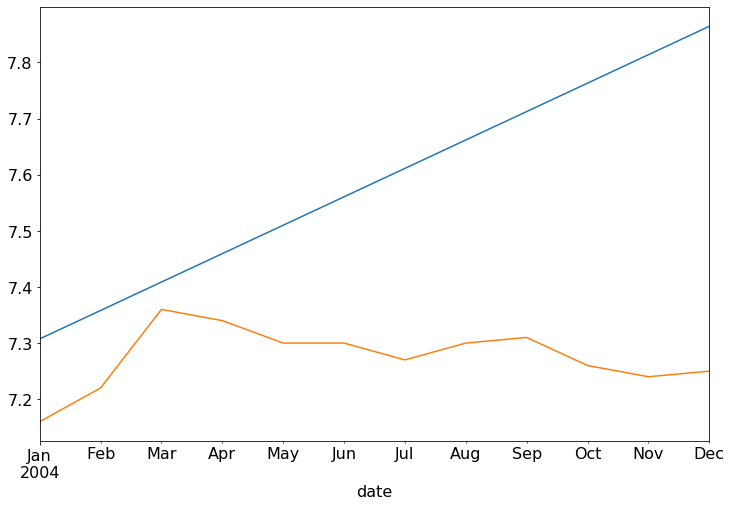

In [110]:
indep_predictions['aaa'].plot()
bankdata_test['aaa'].plot()

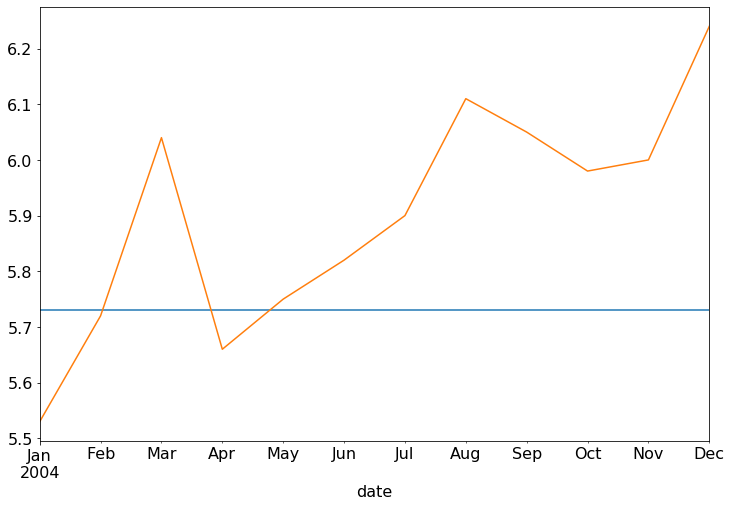

In [111]:
indep_predictions['mo_34'].plot()
bankdata_test['mo_34'].plot()